In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Gradient Descent 

Two types

- Batch Gradient Descent : Entire training set used as a batch for iterative optimization
- Stochastic Gradient Descent : A small section of training data used for iterative optimization, ```n``` number of times, final weights/coefficients will be the average of the n SGD models
- Mini-Batch Gradient Descent : balance b/w batch gradient descent and stochastic gradient descent

Plan:
Derive GD for Linear Regression (MSE)

Implement BGD from scratch

Add SGD and Mini-Batch

Visualize convergence (contour plots, loss curves)

Introduce momentum-based methods

Implement and compare Adam, RMSProp, etc.

Debug with gradient checking (optional)

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
os.chdir(project_root)
sys.path.append(project_root)
print("New working directory:", os.getcwd())

New working directory: c:\Users\Atharva Kulkarni\Desktop\Programming\ML PROJECTS\ML from Scratch\MLfromScratch


In [3]:
from src.core.train_test_split import train_test_split

# BATCH GRADIENT DESCENT

In [ ]:
class BatchGradientDescent:
    def __init__(self, alpha=0.001, max_iter=1000, tol=1e-3, early_stopping=False, n_iter_no_change=5, validation_fraction=0.1, shuffle=True, fit_intercept=True, random_state=None):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.early_stopping = early_stopping
        self.n_iter_no_change = n_iter_no_change
        self.validation_fraction = validation_fraction
        self.shuffle = shuffle
        self.random_state = random_state 
        self.fit_intercept = fit_intercept
        
        self.train_loss_history_ = []
        self.val_loss_history_ = []
        self.intercept_ = None

    def fit(self, X_train, y_train):

        if self.random_state:
            np.random.seed(self.random_state)
        
        self.coeff_ = np.zeros(X_train.shape[1])
        best_val_loss = float('inf')
        no_improve_count = 0

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=self.validation_fraction, shuffle=self.shuffle, stratify=False, random_state=42)
        if self.fit_intercept:
            self.X_mean_ = np.mean(X_train, axis=0)
            self.y_mean_ = np.mean(y_train)
            X_train = X_train - self.X_mean_
            y_train = y_train - self.y_mean_
            X_val = X_val - self.X_mean_
            y_val = y_val - self.y_mean_
        else:
            self.X_mean_ = None
            self.y_mean_ = None
            
        for iter in range(self.max_iter):
            y_pred = X_train @ self.coeff_
            gradient = (2/X_train.shape[0]) * X_train.T @ ( y_pred - y_train ) 
            new_coeff_ = self.coeff_ - self.alpha * gradient

            val_pred = X_val@new_coeff_
            val_loss = np.mean((val_pred - y_val)**2)
            train_loss = np.mean((y_pred - y_train) ** 2)

            self.train_loss_history_.append(train_loss)
            self.val_loss_history_.append(val_loss)

            if best_val_loss - val_loss > self.tol:
                best_val_loss=val_loss
                no_improve_count=0
            else:
                no_improve_count+=1

            self.coeff_ = new_coeff_

            if self.early_stopping and no_improve_count > self.n_iter_no_change:
                break
        
        if self.fit_intercept:
            self.intercept_ = self.y_mean_ - self.X_mean_ @ self.coeff_

    def predict(self, X_test):
        if self.fit_intercept:
            X_test = X_test - self.X_mean_
            return X_test @ self.coeff_ + self.intercept_
        else:
            return X_test @ self.coeff_

    def score(self, y_pred, y_test):
        mse = np.mean((y_pred - y_test)**2)
        rmse = np.sqrt(mse)
        return rmse
        

In [7]:
import numpy as np

np.random.seed(42)  # For reproducibility

# Generate 100 samples, 3 features
X = np.random.rand(100, 3) * 10  # Features in range [0, 10)

# True coefficients
true_coeffs = np.array([2.5, -1.7, 3.3])

# Linear relation + noise
y = X @ true_coeffs + np.random.randn(100) * 2.0  # Add Gaussian noise

# Split manually
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=False, random_state=42)

bgd = BatchGradientDescent()

bgd.fit(X,y)
y_pred = bgd.predict(X_test)
rmse = bgd.score(y_pred, y_test)
rmse

np.float64(2.652212340290644)

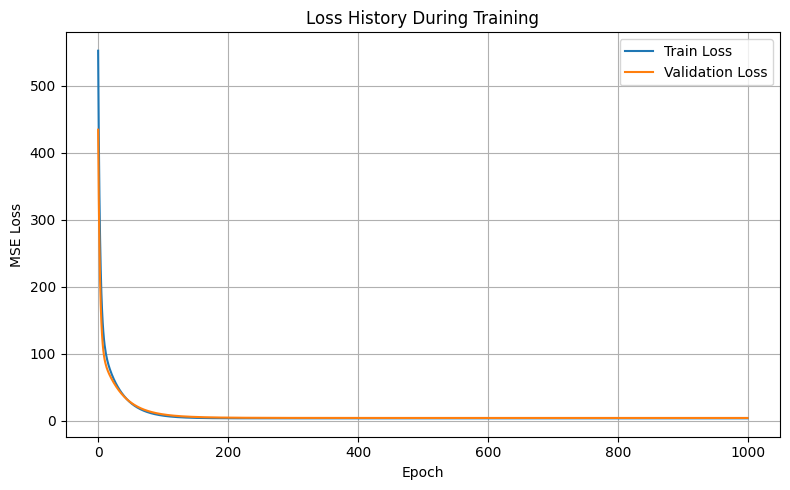

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(bgd.train_loss_history_, label="Train Loss")
plt.plot(bgd.val_loss_history_, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss History During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

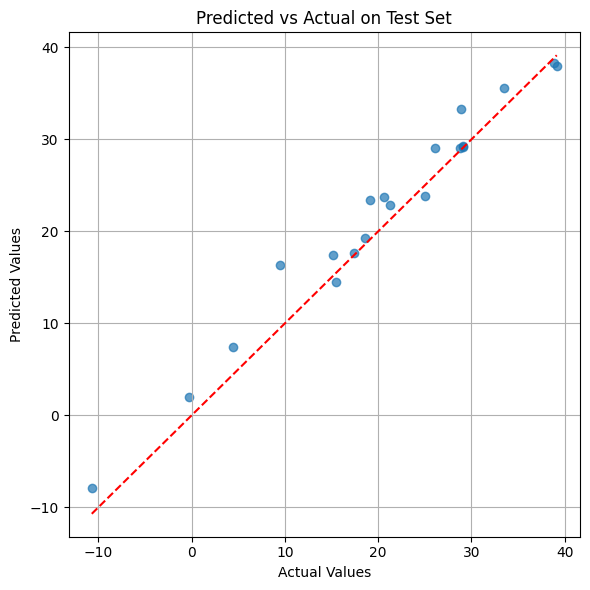

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual on Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()


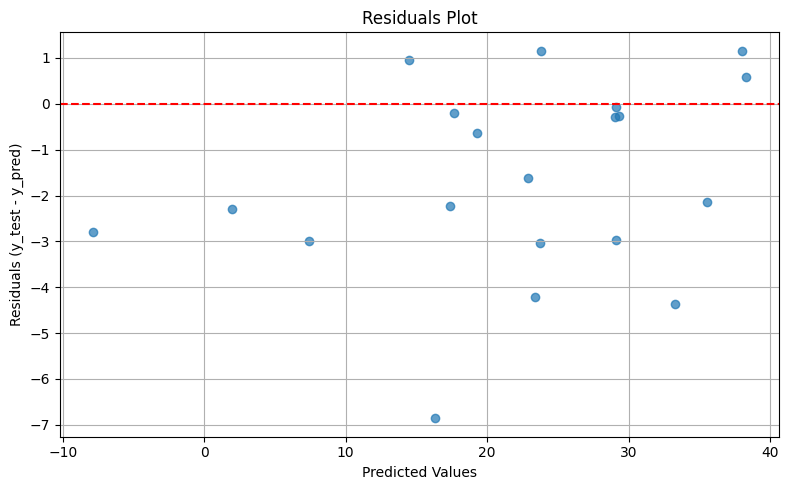

In [10]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residuals Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


# STOCHASTIC GRADIENT DESCENT

In [ ]:
class StochasticGradientDescent:
    def __init__(self, alpha=0.001, max_iter=1000, tol=1e-3, early_stopping=False, n_iter_no_change=5, validation_fraction=0.1, shuffle=True, fit_intercept = True ,average=True, random_state=None):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.early_stopping = early_stopping
        self.n_iter_no_change = n_iter_no_change
        self.validation_fraction = validation_fraction
        self.shuffle = shuffle
        self.random_state = random_state
        self.fit_intercept = fit_intercept
        self.average = average

        self.train_loss_history_ = []
        self.val_loss_history_ = []
        self.intercept = None

    def fit(self, X_train, y_train):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.coeff_ = np.zeros(X_train.shape[1])
        best_val_loss = float('inf')
        no_improve_count = 0
        
        if self.average:
            self.avg_coeff_ = np.zeros_like(self.coeff_)
            total_updates = 0


        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=self.validation_fraction, shuffle=self.shuffle, stratify=False, random_state=42)
        if self.fit_intercept:
            self.X_mean_ = np.mean(X_train, axis=0)
            self.y_mean_ = np.mean(y_train)
            X_train = X_train - self.X_mean_
            y_train = y_train - self.y_mean_
            X_val = X_val - self.X_mean_
            y_val = y_val - self.y_mean_
        else:
            self.X_mean_ = None
            self.y_mean_ = None
            
        for epoch in range(self.max_iter):
            if self.shuffle:
                indices = np.arange(X_train.shape[0])
                np.random.shuffle(indices)
                X_train = X_train[indices]
                y_train = y_train[indices]

            # Stochastic updates
            for i in range(X_train.shape[0]):
                xi = X_train[i]
                yi = y_train[i]
                y_pred = xi @ self.coeff_
                gradient = 2 * xi.T * (y_pred - yi)
                self.coeff_ -= self.alpha * gradient
                
                if self.average:
                    total_updates += 1
                    self.avg_coeff_ += (self.coeff_ - self.avg_coeff_) / total_updates

            # Compute full-batch losses (per epoch)
            train_pred = X_train @ self.coeff_
            val_pred = X_val @ self.coeff_
            train_loss = np.mean((train_pred - y_train) ** 2)
            val_loss = np.mean((val_pred - y_val) ** 2)

            self.train_loss_history_.append(train_loss)
            self.val_loss_history_.append(val_loss)

            # Early stopping check
            if best_val_loss - val_loss > self.tol:
                best_val_loss = val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1

            if self.early_stopping and no_improve_count > self.n_iter_no_change:
                break
        
        if self.average:
            self.coeff_ = self.avg_coeff_

        
        if self.fit_intercept:
            self.intercept_ = self.y_mean_ - self.X_mean_ @ self.coeff_

    def partial_fit(self, X_batch, y_batch):
        # Initialize weights on first call
        if not hasattr(self, 'coeff_'):
            self.coeff_ = np.zeros(X_batch.shape[1])
            if self.average:
                self.avg_coeff_ = np.zeros_like(self.coeff_)
                self.total_updates_ = 0
            if self.fit_intercept:
                self.X_mean_ = np.mean(X_batch, axis=0)
                self.y_mean_ = np.mean(y_batch)
            else:
                self.X_mean_ = None
                self.y_mean_ = None

        # Center data if intercept is used
        if self.fit_intercept:
            X_batch = X_batch - self.X_mean_
            y_batch = y_batch - self.y_mean_

        for i in range(X_batch.shape[0]):
            xi = X_batch[i]
            yi = y_batch[i]
            y_pred = xi @ self.coeff_
            gradient = 2 * xi.T * (y_pred - yi)
            self.coeff_ -= self.alpha * gradient

            if self.average:
                self.total_updates_ += 1
                self.avg_coeff_ += (self.coeff_ - self.avg_coeff_) / self.total_updates_

        if self.average:
            self.coeff_ = self.avg_coeff_
            
        if self.fit_intercept:
            self.intercept_ = self.y_mean_ - self.X_mean_ @ self.coeff_

    
    def predict(self, X_test):
        if self.fit_intercept:
            X_test = X_test - self.X_mean_
            return X_test @ self.coeff_ + self.intercept_
        else:
            return X_test @ self.coeff_

    def score(self, y_pred, y_test):
        mse = np.mean((y_pred - y_test) ** 2)
        rmse = np.sqrt(mse)
        return rmse


In [16]:
import numpy as np

np.random.seed(42)  # For reproducibility

# Generate 100 samples, 3 features
X = np.random.rand(100, 6) * 10  # Features in range [0, 10)

# True coefficients
true_coeffs = np.array([2.8, -1.7, 3.3, 6.1, -2.7, 1.4])

# Linear relation + noise
y = X @ true_coeffs + np.random.randn(100) * 4.0  # Add Gaussian noise

# Split manually
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=False, random_state=42)

sgd = StochasticGradientDescent()

sgd.fit(X,y)
y_pred = sgd.predict(X_test)
rmse = sgd.score(y_pred, y_test)
rmse

np.float64(3.6598327355604585)

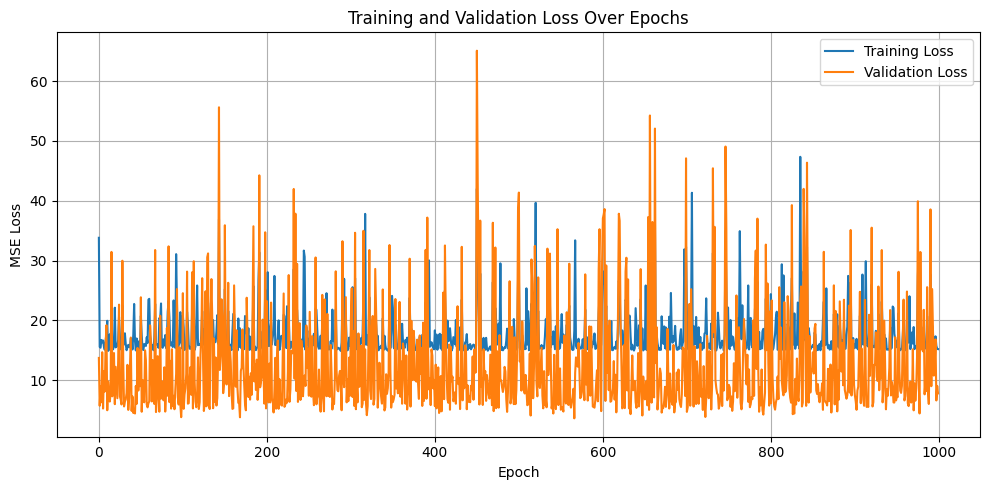

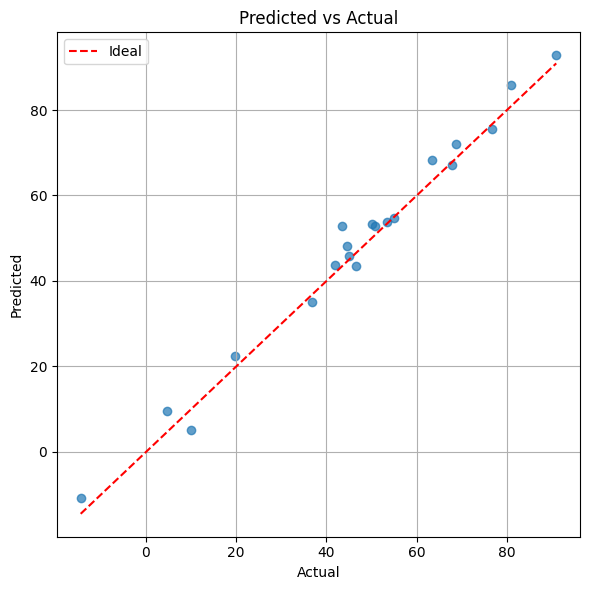

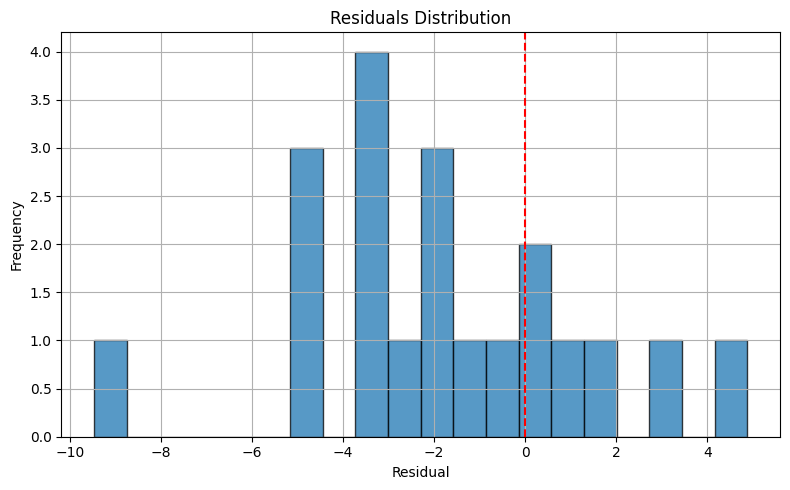

In [18]:
import matplotlib.pyplot as plt

# 1. Loss curves
plt.figure(figsize=(10, 5))
plt.plot(sgd.train_loss_history_, label='Training Loss')
plt.plot(sgd.val_loss_history_, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


# MINI BATCH STOCHASTIC GRADIENT DESCENT

In [ ]:
import numpy as np

class MiniBatchStochasticGradientDescent:
    def __init__(self, alpha=0.001, max_iter=1000, tol=1e-3, fit_intercept = True, early_stopping=False, n_iter_no_change=5, validation_fraction=0.1, shuffle=True, batch_size=32, average=True, random_state=None):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.n_iter_no_change = n_iter_no_change
        self.validation_fraction = validation_fraction
        self.shuffle = shuffle
        self.fit_intercept = fit_intercept
        self.random_state = random_state
        self.average=average

        self.train_loss_history_ = []
        self.val_loss_history_ = []
        self.intercept_ = None

    def fit(self, X_train, y_train):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.coeff_ = np.zeros(X_train.shape[1])
        best_val_loss = float('inf')
        no_improve_count = 0
        
        if self.average:
            self.avg_coeff_ = np.zeros_like(self.coeff_)
            total_updates = 0

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=self.validation_fraction, shuffle=self.shuffle, stratify=False, random_state=42)
        if self.fit_intercept:
            self.X_mean_ = np.mean(X_train, axis=0)
            self.y_mean_ = np.mean(y_train)
            X_train = X_train - self.X_mean_
            y_train = y_train - self.y_mean_
            X_val = X_val - self.X_mean_
            y_val = y_val - self.y_mean_
        else:
            self.X_mean_ = None
            self.y_mean_ = None

        for epoch in range(self.max_iter):
            if self.shuffle:
                indices = np.arange(X_train.shape[0])
                np.random.shuffle(indices)
                X_train = X_train[indices]
                y_train = y_train[indices]

            for start in range(0, X_train.shape[0], self.batch_size):
                end = start + self.batch_size
                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                y_pred = X_batch @ self.coeff_
                gradient = 2 * X_batch.T @ (y_pred - y_batch) / X_batch.shape[0]
                self.coeff_ -= self.alpha * gradient
                
                if self.average:
                    total_updates += 1
                    self.avg_coeff_ += (self.coeff_ - self.avg_coeff_) / total_updates

            train_pred = X_train @ self.coeff_
            val_pred = X_val @ self.coeff_
            train_loss = np.mean((train_pred - y_train) ** 2)
            val_loss = np.mean((val_pred - y_val) ** 2)

            self.train_loss_history_.append(train_loss)
            self.val_loss_history_.append(val_loss)

            if best_val_loss - val_loss > self.tol:
                best_val_loss = val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1

            if self.early_stopping and no_improve_count > self.n_iter_no_change:
                break
        
        if self.average:
            self.coeff_ = self.avg_coeff_
        
        if self.fit_intercept:
            self.intercept_ = self.y_mean_ - self.X_mean_ @ self.coeff_

    def partial_fit(self, X_batch, y_batch):
        if not hasattr(self, 'coeff_'):
            self.coeff_ = np.zeros(X_batch.shape[1])
            if self.average:
                self.avg_coeff_ = np.zeros_like(self.coeff_)
                self.total_updates_ = 0
            if self.fit_intercept:
                self.X_mean_ = np.mean(X_batch, axis=0)
                self.y_mean_ = np.mean(y_batch)
            else:
                self.X_mean_ = None
                self.y_mean_ = None

        if self.fit_intercept:
            X_batch = X_batch - self.X_mean_
            y_batch = y_batch - self.y_mean_

        y_pred = X_batch @ self.coeff_
        gradient = 2 * X_batch.T @ (y_pred - y_batch) / X_batch.shape[0]
        self.coeff_ -= self.alpha * gradient

        if self.average:
            self.total_updates_ += 1
            self.avg_coeff_ += (self.coeff_ - self.avg_coeff_) / self.total_updates_
            self.coeff_ = self.avg_coeff_

        if self.fit_intercept:
            self.intercept_ = self.y_mean_ - self.X_mean_ @ self.coeff_


    def predict(self, X_test):
        if self.fit_intercept:
            X_test = X_test - self.X_mean_
            return X_test @ self.coeff_ + self.intercept_
        else:
            return X_test @ self.coeff_

    def score(self, y_pred, y_test):
        mse = np.mean((y_pred - y_test) ** 2)
        rmse = np.sqrt(mse)
        return rmse


In [7]:
import numpy as np

np.random.seed(42)  # For reproducibility

# Generate 100 samples, 3 features
X = np.random.rand(100, 6) * 10  # Features in range [0, 10)

# True coefficients
true_coeffs = np.array([2.8, -1.7, 3.3, 6.1, -2.7, 1.4])

# Linear relation + noise
y = X @ true_coeffs + np.random.randn(100) * 4.0  # Add Gaussian noise

# Split manually
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=False, random_state=42)

mbsgd = MiniBatchStochasticGradientDescent()

mbsgd.fit(X,y)
y_pred = mbsgd.predict(X_test)
rmse = mbsgd.score(y_pred, y_test)
rmse

np.float64(3.790518612744317)

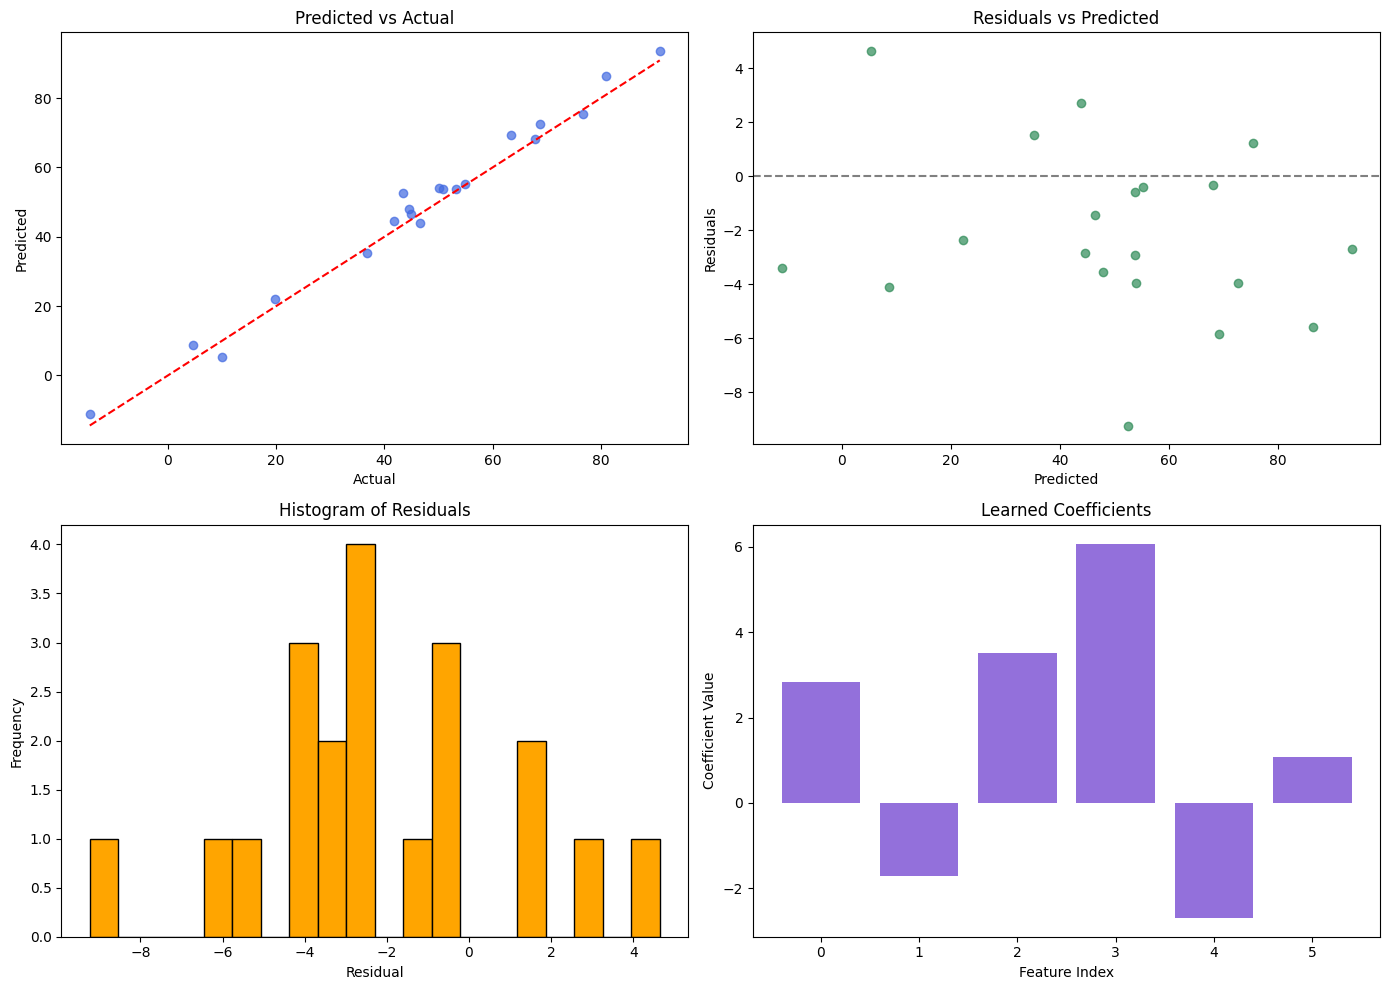

In [9]:
import matplotlib.pyplot as plt 
# Generate predictions and compute residuals
y_pred = mbsgd.predict(X_test)
residuals = y_test - y_pred

# Set up multiple plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicted vs Actual
axs[0, 0].scatter(y_test, y_pred, alpha=0.7, color='royalblue')
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')
axs[0, 0].set_title('Predicted vs Actual')

# 2. Residuals Plot
axs[0, 1].scatter(y_pred, residuals, alpha=0.7, color='seagreen')
axs[0, 1].axhline(0, linestyle='--', color='gray')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].set_title('Residuals vs Predicted')

# 3. Histogram of Residuals
axs[1, 0].hist(residuals, bins=20, color='orange', edgecolor='black')
axs[1, 0].set_xlabel('Residual')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Histogram of Residuals')

# 4. Coefficients Bar Chart
axs[1, 1].bar(range(len(mbsgd.coeff_)), mbsgd.coeff_, color='mediumpurple')
axs[1, 1].set_xlabel('Feature Index')
axs[1, 1].set_ylabel('Coefficient Value')
axs[1, 1].set_title('Learned Coefficients')

plt.tight_layout()
plt.show()
